<a href="https://colab.research.google.com/github/chemicoPy/MACD-RSI-STOCHASTIC-strategy/blob/Binance-API/MACD_RSI_STOCHASTIC_strategy_(Binance_API).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install python-binance

     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 288 kB 27.8 MB/s 
     |████████████████████████████████| 1.1 MB 67.6 MB/s 
     |████████████████████████████████| 103 kB 72.0 MB/s 
     |████████████████████████████████| 271 kB 85.7 MB/s 
     |████████████████████████████████| 160 kB 84.3 MB/s 
     |████████████████████████████████| 192 kB 85.4 MB/s 


In [ ]:
from binance import Client
from binance import Client, ThreadedWebsocketManager
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date


In [ ]:
actual_api_key = ""
actual_secret_key = ""

""" Examples_of_coins_are = ["BNBUSDT", "ETHUSDT", "ADAUSDT", "DOTUSDT", "BTCUSDT", "FTMUSDT", "DOGEUSDT", "LINKUSDT", "SUSHIUSDT", "SOLUSDT",
                 "IOSTUSDT", "LTCUSDT", "XRPUSDT", "SXPUSDT", "MATICUSDT", "BCHUSDT"] """


coin = str(input("Enter coin name: ").upper())
time_interval = str(input("Enter time interval name e.g 5m for 5-minute, 1h for 1hour: ").lower())

""" For example:
coin = 'BTCUSDT'
interval = '1m' """

Enter coin name: btcusdt
Enter time interval name e.g 5m for 5-minute, 1h for 1hour: 1h


" For example:\ncoin = 'BTCUSDT'\ninterval = '1m' "

In [ ]:

# Client Initialization using real API from an existing Binance Account

client = Client(actual_api_key, actual_secret_key)

# Getting Data from Binance API and earliest timestamp available (on Binance)

earliest_timestamp = client._get_earliest_valid_timestamp(coin, time_interval)
print(earliest_timestamp)

# Getting historical data (candle data or kline)
candle = client.get_historical_klines(coin, time_interval, earliest_timestamp)

df = pd.DataFrame(candle, columns=['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'])
df.dateTime = pd.to_datetime(df.dateTime, unit='ms')
df.closeTime = pd.to_datetime(df.closeTime,unit='ms')
df.set_index('dateTime', inplace=True)
df.drop(['closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'], axis = 'columns', inplace = True)
df['open'] = pd.to_numeric(df['open'], errors='coerce')
df['high'] = pd.to_numeric(df['high'], errors='coerce')
df['low'] = pd.to_numeric(df['low'], errors='coerce')
df['close'] = pd.to_numeric(df['close'], errors='coerce')
df['volume'] = pd.to_numeric(df['volume'], errors='coerce')
print(df.tail(5))
print("")
print("Size of data:", len(df))

#df.to_csv('candle.csv')   #to download or save as csv file


1502942400000
                         open      high       low     close      volume
dateTime                                                               
2022-01-16 12:00:00  42968.30  43141.55  42954.16  43005.93   644.99288
2022-01-16 13:00:00  43005.93  43187.87  42581.79  43129.54  2260.54268
2022-01-16 14:00:00  43129.54  43416.05  43026.70  43300.02  1422.48883
2022-01-16 15:00:00  43300.01  43350.00  43139.24  43219.53   997.18364
2022-01-16 16:00:00  43219.54  43475.00  43172.01  43346.15   887.22637

Size of data: 38599


# Data pulled is as far back as 2017

In [ ]:
df.head()

,open,high,low,close,volume
dateTime,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807


In [ ]:
df = df.tail(1000) # using just 1000 of the huge data grabbed


# MACD - Moving Average Convergence Divergence

In [ ]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df
    
macd = get_macd(df['close'], 26, 12, 9)
df = pd.concat([df, macd], join = 'inner', axis = 1)
df.tail()

,open,high,low,close,volume,macd,signal,hist
dateTime,,,,,,,,
2022-01-16 12:00:00,42968.30,43141.55,42954.16,43005.93,644.99288,-25.745546,-3.723464,-22.022082
2022-01-16 13:00:00,43005.93,43187.87,42581.79,43129.54,2260.54268,-17.318073,-6.442386,-10.875687
2022-01-16 14:00:00,43129.54,43416.05,43026.70,43300.02,1422.48883,3.081550,-4.537599,7.619148
2022-01-16 15:00:00,43300.01,43350.00,43139.24,43219.53,997.18364,12.608187,-1.108442,13.716629
2022-01-16 16:00:00,43219.54,43475.00,43172.01,43346.15,887.22637,30.029135,5.119074,24.910061


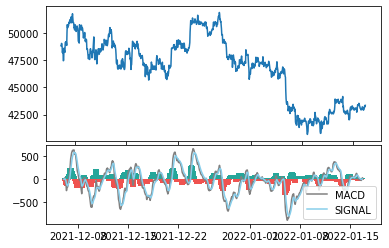

In [ ]:
def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(df['close'], df['macd'], df['signal'], df['hist'])


In [ ]:
def implement_macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal
            
buy_price, sell_price, macd_signal = implement_macd_strategy(df['close'], df)

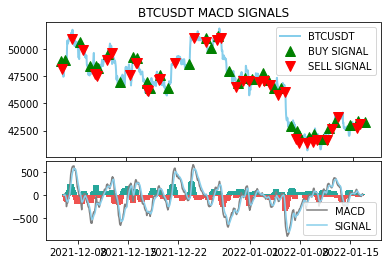

In [ ]:
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(df['close'], color = 'skyblue', linewidth = 2, label = str(coin))
ax1.plot(df.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(df.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title(str(coin+" MACD SIGNALS"))
ax2.plot(df['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(df['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(df)):
    if str(df['hist'][i])[0] == '-':
        ax2.bar(df.index[i], df['hist'][i], color = '#ef5350')
    else:
        ax2.bar(df.index[i], df['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()


In [ ]:
macd_signal

In [ ]:
position = []
for i in range(len(macd_signal)):
    if macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(df['close'])):
    if macd_signal[i] == 1:
        position[i] = 1
    elif macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
macd = df['macd']
signal = df['signal']
close_price = df['close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(df.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(df.index)

frames = [close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,close,macd,signal,macd_signal,macd_position
dateTime,,,,,
2021-12-06 01:00:00,48804.19,0.000000,0.000000,0,1
2021-12-06 02:00:00,48862.09,4.618803,0.923761,1,1
2021-12-06 03:00:00,49018.47,20.659646,4.870938,0,1
2021-12-06 04:00:00,48979.66,29.895866,9.875923,0,1
2021-12-06 05:00:00,48678.54,12.770558,10.454850,0,1
...,...,...,...,...,...
2022-01-16 12:00:00,43005.93,-25.745546,-3.723464,0,0
2022-01-16 13:00:00,43129.54,-17.318073,-6.442386,0,0
2022-01-16 14:00:00,43300.02,3.081550,-4.537599,1,1


# RSI - Relative Strength Index

In [ ]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

df['rsi_14'] = get_rsi(df['close'], 14)
df = df.dropna()


In [ ]:
df

,open,high,low,close,volume,macd,signal,hist,rsi_14
dateTime,,,,,,,,,
2021-12-06 05:00:00,48979.66,49084.61,48678.54,48678.54,998.37176,12.770558,10.454850,2.315708,69.923674
2021-12-06 06:00:00,48678.55,48754.56,48035.01,48168.04,1708.61083,-41.515886,0.060703,-41.576589,46.915282
2021-12-06 07:00:00,48166.51,48433.00,47731.00,48412.66,2701.85588,-64.061039,-12.763645,-51.297394,54.620768
2021-12-06 08:00:00,48412.66,49409.79,47828.48,48157.00,4798.68537,-101.389110,-30.488738,-70.900371,46.950262
2021-12-06 09:00:00,48160.15,48327.40,47100.00,47428.17,4152.07642,-187.619603,-61.914911,-125.704691,32.806287
...,...,...,...,...,...,...,...,...,...
2022-01-16 12:00:00,42968.30,43141.55,42954.16,43005.93,644.99288,-25.745546,-3.723464,-22.022082,47.301613
2022-01-16 13:00:00,43005.93,43187.87,42581.79,43129.54,2260.54268,-17.318073,-6.442386,-10.875687,52.033905
2022-01-16 14:00:00,43129.54,43416.05,43026.70,43300.02,1422.48883,3.081550,-4.537599,7.619148,57.678580


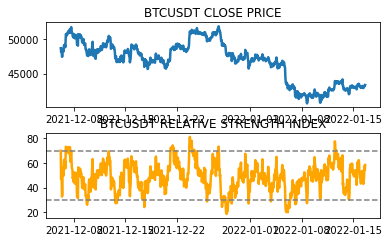

In [ ]:
ax3 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax4 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax3.plot(df['close'], linewidth = 2.5)
ax3.set_title(str(coin+" CLOSE PRICE"))
ax4.plot(df['rsi_14'], color = 'orange', linewidth = 2.5)
ax4.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax4.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
ax4.set_title(str(coin+" RELATIVE STRENGTH INDEX"))
plt.show()

In [ ]:
def implement_rsi_strategy(prices, rsi):    
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0

    for i in range(len(rsi)):
        if rsi[i-1] > 30 and rsi[i] < 30:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i-1] < 70 and rsi[i] > 70:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal
            

rsi_buy_price, rsi_sell_price, rsi_signal = implement_rsi_strategy(df['close'], df['rsi_14'])

In [ ]:
df

,open,high,low,close,volume,macd,signal,hist,rsi_14
dateTime,,,,,,,,,
2021-12-06 05:00:00,48979.66,49084.61,48678.54,48678.54,998.37176,12.770558,10.454850,2.315708,69.923674
2021-12-06 06:00:00,48678.55,48754.56,48035.01,48168.04,1708.61083,-41.515886,0.060703,-41.576589,46.915282
2021-12-06 07:00:00,48166.51,48433.00,47731.00,48412.66,2701.85588,-64.061039,-12.763645,-51.297394,54.620768
2021-12-06 08:00:00,48412.66,49409.79,47828.48,48157.00,4798.68537,-101.389110,-30.488738,-70.900371,46.950262
2021-12-06 09:00:00,48160.15,48327.40,47100.00,47428.17,4152.07642,-187.619603,-61.914911,-125.704691,32.806287
...,...,...,...,...,...,...,...,...,...
2022-01-16 12:00:00,42968.30,43141.55,42954.16,43005.93,644.99288,-25.745546,-3.723464,-22.022082,47.301613
2022-01-16 13:00:00,43005.93,43187.87,42581.79,43129.54,2260.54268,-17.318073,-6.442386,-10.875687,52.033905
2022-01-16 14:00:00,43129.54,43416.05,43026.70,43300.02,1422.48883,3.081550,-4.537599,7.619148,57.678580


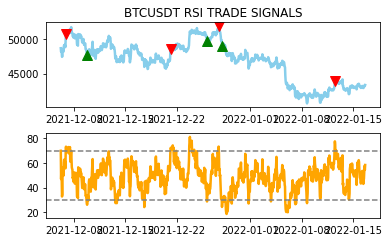

In [ ]:
ax5 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax6 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
ax5.plot(df['close'], linewidth = 2.5, color = 'skyblue', label = 'RSI')
ax5.plot(df.index, rsi_buy_price, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
ax5.plot(df.index, rsi_sell_price, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax5.set_title(str(coin+" RSI TRADE SIGNALS"))
ax6.plot(df['rsi_14'], color = 'orange', linewidth = 2.5)
ax6.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
ax6.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
plt.show()

In [ ]:
position = []
for i in range(len(rsi_signal)):
    if rsi_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(df['close'])):
    if rsi_signal[i] == 1:
        position[i] = 1
    elif rsi_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
rsi = df['rsi_14']
close_price = df['close']
rsi_signal = pd.DataFrame(rsi_signal).rename(columns = {0:'rsi_signal'}).set_index(df.index)
position = pd.DataFrame(position).rename(columns = {0:'rsi_position'}).set_index(df.index)

frames = [close_price, rsi, rsi_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy.head()

,close,rsi_14,rsi_signal,rsi_position
dateTime,,,,
2021-12-06 05:00:00,48678.54,69.923674,0,1
2021-12-06 06:00:00,48168.04,46.915282,0,1
2021-12-06 07:00:00,48412.66,54.620768,0,1
2021-12-06 08:00:00,48157.00,46.950262,0,1
2021-12-06 09:00:00,47428.17,32.806287,0,1


# STOCHASTIC OSCILLATOR

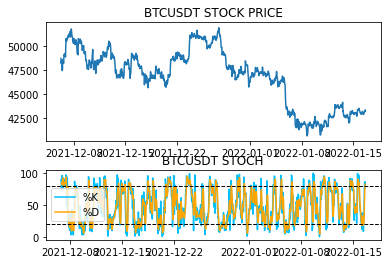

In [ ]:

stoch_data = df.copy()

stoch_data['high'] = stoch_data['high'].rolling(14).max()
stoch_data['low'] = stoch_data['low'].rolling(14).min()
stoch_data['%k'] = (stoch_data["close"] - stoch_data['low'])*100/(stoch_data['high'] - stoch_data['low'])
stoch_data['%d'] = stoch_data['%k'].rolling(3).mean()

def plot_stoch(price, k, d):
    ax7 = plt.subplot2grid((9, 1), (0,0), rowspan = 5, colspan = 1)
    ax8 = plt.subplot2grid((9, 1), (6,0), rowspan = 3, colspan = 1)
    ax7.plot(price)
    ax7.set_title(f'{coin} STOCK PRICE')
    ax8.plot(k, color = 'deepskyblue', linewidth = 1.5, label = '%K')
    ax8.plot(d, color = 'orange', linewidth = 1.5, label = '%D')
    ax8.axhline(80, color = 'black', linewidth = 1, linestyle = '--')
    ax8.axhline(20, color = 'black', linewidth = 1, linestyle = '--')
    ax8.set_title(f'{coin} STOCH')
    ax8.legend()
    plt.show()
    
plot_stoch(df['close'], stoch_data['%k'], stoch_data['%d'])

In [ ]:
def implement_stoch_strategy(prices, k, d):    
    buy_price = []
    sell_price = []
    stoch_signal = []
    signal = 0

    for i in range(len(prices)):
        if k[i] < 20 and d[i] < 20 and k[i] < d[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                stoch_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_signal.append(0)
        elif k[i] > 80 and d[i] > 80 and k[i] > d[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                stoch_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            stoch_signal.append(0)
            
    return buy_price, sell_price, stoch_signal
            
stoch_buy_price, stoch_sell_price, stoch_signal = implement_stoch_strategy(stoch_data['close'], stoch_data['%k'], stoch_data['%d'])

In [ ]:
position = []
for i in range(len(stoch_signal)):
    if stoch_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(stoch_data['close'])):
    if stoch_signal[i] == 1:
        position[i] = 1
    elif stoch_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
k = stoch_data['%k']
d = stoch_data['%d']
close_price = stoch_data['close']
stoch_signal = pd.DataFrame(stoch_signal).rename(columns = {0:'stoch_signal'}).set_index(stoch_data.index)
position = pd.DataFrame(position).rename(columns = {0:'stoch_position'}).set_index(stoch_data.index)

frames = [close_price, k, d, stoch_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy.tail()

,close,%k,%d,stoch_signal,stoch_position
dateTime,,,,,
2022-01-16 12:00:00,43005.93,40.086039,27.280613,0,1
2022-01-16 13:00:00,43129.54,75.738720,49.519003,0,1
2022-01-16 14:00:00,43300.02,86.091866,67.305542,0,1
2022-01-16 15:00:00,43219.53,76.443795,79.424794,0,1
2022-01-16 16:00:00,43346.15,85.574501,82.703387,-1,0
